In [1]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import joblib
import os

In [2]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

In [3]:
# step 2
from extract_features import process_dataset
process_dataset('inference')

[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


  1%|          | 4/473 [00:00<00:13, 34.14it/s]

100%|██████████| 473/473 [00:06<00:00, 69.03it/s]


Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,2.578586,2.362892,8.999561,-5.200753,14.200314,0.193760,1.400440,31,1223.236383,2.995496,...,12,49,996,S603575,v1.3.0,ok,79,5.570705,4g,model_c
1,-0.114423,2.185548,10.289834,-5.283784,15.573618,2.164783,7.702143,5,478.971240,0.343485,...,22,75,607,S949312,v1.2.4,ok,81,3.181146,4g,model_c
2,0.061702,0.147340,0.291371,-0.208436,0.499806,-0.407912,-1.211002,15,2.551629,0.015451,...,30,52,482,S223545,v1.2.3,recent,95,2.987759,4g,model_b
3,1.354891,2.486652,11.114359,-6.365416,17.479775,0.764660,3.152818,15,801.916607,1.424555,...,11,36,463,S993755,v1.2.3,pending,47,9.744692,4g,model_a
4,0.061687,0.141320,0.278571,-0.246872,0.525443,-0.440889,-1.157643,17,2.377675,0.018567,...,13,41,759,S734746,v1.2.4,recent,37,3.622219,wifi,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.060402,0.141580,0.300225,-0.230982,0.531207,-0.394775,-1.216041,14,2.369336,0.015395,...,15,57,750,S165342,v1.2.4,ok,54,9.761510,4g,model_c
469,0.159769,2.509925,8.347333,-9.574540,17.921873,0.287556,3.356591,10,632.524802,1.805974,...,12,76,900,S653588,v1.3.0,pending,23,8.203065,4g,model_a
470,-0.548699,2.591718,6.550702,-8.426525,14.977227,-0.191147,1.450593,11,701.807315,1.414847,...,22,77,11,S945979,v1.3.0,pending,80,5.033353,5g,model_b
471,-0.559437,1.851954,4.829766,-6.744202,11.573968,-0.103196,1.832355,9,374.270158,1.994104,...,29,50,831,S424057,v1.3.0,pending,83,1.703700,5g,model_c


In [4]:
# step 3
import pandas as pd
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")
labels.shape

(473, 2)

In [5]:
# show sample
labels[:10]

,sample_id,label
0,b67dd849-bf1a-4083-a09b-e56eea5b58ca,collision
1,2fe95d3e-1db2-420e-a9b6-880a3e76251c,collision
2,3b0de448-dd4c-4300-949c-1d58b8f32795,collision
3,e38b956f-e34f-4527-8cd7-8890fd0b2b76,collision
4,284498b7-94bd-42fe-9e57-814554fab41f,collision
5,7965c2bd-e17a-4d7f-acfc-156805cc41a0,collision
6,0c898243-2688-47ed-babb-5001263ee6a3,collision
7,68115c10-b0e5-4cc6-88a6-d2db1d0c5502,collision
8,561523f2-8644-4785-89d6-16158dc7ffb8,collision
9,01b5f718-2978-468f-9789-89003ba755e6,collision


In [6]:
# step 4 - with modification
import joblib
from imu_pipeline import IMUPipeline

df_inf = pd.read_csv("data/inference.csv")
model = joblib.load("models/imu_pipeline.pkl")

# inference.csv and infrence labels arent sorted the same. Reindexing here to make it easier to visualise
df_inf = df_inf.set_index("sample_id").reindex(labels["sample_id"]).reset_index()
df_inf.shape

(473, 60)

In [7]:
preds = model.predict(df_inf)
probs = model.predict_proba(df_inf)
preds.shape, probs.shape

((473,), (473, 2))

In [8]:
# show pred sample
for i in zip(preds[:10],probs[:10]):
    print(i)

('collision', array([0.96, 0.04]))
('collision', array([0.97, 0.03]))
('collision', array([0.94, 0.06]))
('collision', array([1., 0.]))
('collision', array([1., 0.]))
('collision', array([0.98, 0.02]))
('collision', array([1., 0.]))
('collision', array([0.95, 0.05]))
('collision', array([1., 0.]))
('collision', array([1., 0.]))


In [9]:
# step 5
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [10]:
# metrics
accuracy = accuracy_score(labels["label"], preds)
precision = precision_score(labels["label"], preds, pos_label="collision")
recall = recall_score(labels["label"], preds, pos_label="collision")
f1 = f1_score(labels["label"], preds, pos_label="collision")

inf_metrics = {
    "Accuracy" : accuracy,
    "Precision" : precision,
    "Recall" : recall,
    "F1" : f1
}
inf_metrics

{'Accuracy': 0.6448202959830867,
 'Precision': 0.5885416666666666,
 'Recall': 0.9576271186440678,
 'F1': 0.7290322580645161}

In [11]:
# test set
df_test = pd.read_csv("data/test.csv")
test_labels = df_test.pop("label")
df_test.shape, test_labels.shape

((200, 60), (200,))

In [12]:
preds = model.predict(df_test)
probs = model.predict_proba(df_test)
preds.shape, probs.shape

((200,), (200, 2))

In [13]:
accuracy = accuracy_score(test_labels, preds)
precision = precision_score(test_labels, preds, pos_label="collision")
recall = recall_score(test_labels, preds, pos_label="collision")
f1 = f1_score(test_labels, preds, pos_label="collision")
test_metrics = {
    "Accuracy" : accuracy,
    "Precision" : precision,
    "Recall" : recall,
    "F1" : f1
}

In [14]:
metrics = {
    "inference_metrics" : inf_metrics,
    "test_metrics": test_metrics
}
metrics

{'inference_metrics': {'Accuracy': 0.6448202959830867,
  'Precision': 0.5885416666666666,
  'Recall': 0.9576271186440678,
  'F1': 0.7290322580645161},
 'test_metrics': {'Accuracy': 0.945,
  'Precision': 1.0,
  'Recall': 0.89,
  'F1': 0.9417989417989417}}

In [15]:
# EDA

# First we want to look at the features of our data to see what it includes:
assert len(df_test.columns) == len(df_inf.columns)
assert set(df_test.columns) == set(df_inf.columns)

df_test.columns, (df_test.shape, df_inf.shape)


(Index(['x_mean', 'x_std', 'x_max', 'x_min', 'x_range', 'x_skew', 'x_kurtosis',
        'x_n_peaks', 'x_energy', 'y_mean', 'y_std', 'y_max', 'y_min', 'y_range',
        'y_skew', 'y_kurtosis', 'y_n_peaks', 'y_energy', 'z_mean', 'z_std',
        'z_max', 'z_min', 'z_range', 'z_skew', 'z_kurtosis', 'z_n_peaks',
        'z_energy', 'mag_mean', 'mag_std', 'mag_max', 'max_delta_mag',
        'sudden_change_score', 'x_fft_max', 'x_fft_mean', 'y_fft_max',
        'y_fft_mean', 'z_fft_max', 'z_fft_mean', 'xy_corr', 'xz_corr',
        'yz_corr', 'sample_id', 'sensor_source', 'timestamp', 'weather',
        'driver_id', 'vehicle_type', 'speed_bin', 'road_type', 'time_of_day',
        'temperature', 'humidity', 'altitude', 'session_id', 'firmware_version',
        'calibration_status', 'battery_level', 'gps_accuracy', 'network_type',
        'device_model'],
       dtype='object'),
 ((200, 60), (473, 60)))

# Feature Info

- For each x,y,z we have: mean, std, max, min , range, skew, kurtosis, n_peaks, energy

- We then have some data about the magnitude (assuming mag=magnitude)

- fft values for frequency info

- Correlation 

Looks like these features were related to statistics about the accelerometer and the distributions of x,y,z. 
We also have some external non computer vision related feratures such as:

- Vehicle info

- Weather 

- Time

- Few more

Some of them are numerical and some catagorical. We should evaluate them by groups to make it more organised. 
So first, lets compare x,y,z related features. We will take each feature independantly and attempt to see which ones might cause the difference in metrics.
We can apply some similar stats as the features themselves: 
mean, median*, std, max, min, range, skew, kurtosis
Can write a function that does it for a given feature. 

In [16]:
def get_stats(col):
    return {
        "mean": col.mean(),
        "median": col.median(),
        "std": col.std(),
        "min": col.min(),
        "max": col.max(),
        "range": col.max() - col.min(),
        "skew": col.skew(),
        "kurtosis": col.kurtosis()
    }

def compare_feature(inf_df , test_df, feature):
    # didnt see any nans but just in case
    assert not inf_df[feature].isna().any()
    assert not test_df[feature].isna().any()

    stats_inf = get_stats(inf_df[feature]) 
    stats_test = get_stats(test_df[feature])
    
    # use pd df for later
    comparison = pd.DataFrame([stats_inf, stats_test], index=["inf", "test"])

    # add a diff row so can notice diffs quicker
    comparison.loc["diff"] = np.abs(comparison.loc["inf"] - comparison.loc["test"])
    return comparison

In [17]:
# try one to see how it looks like
feature = "x_mean"
compare_feature(df_inf, df_test, feature)

,mean,median,std,min,max,range,skew,kurtosis
inf,0.334443,0.071445,0.863758,-2.379533,3.306673,5.686205,0.480872,1.018051
test,0.072357,0.063618,0.017860,0.054032,0.115545,0.061513,1.164941,-0.316546
diff,0.262086,0.007827,0.845899,2.433565,3.191128,5.624693,0.684069,1.334597


We can already see that for the first feature "x_mean" there are noticable observations. To put it into context, it looks like the data coming from the inference set is much less stable (at least on the x_axis). But for now, it would be good to qunatify this and somehow give a diff score. In this way we can find the features which have the highest difference between the two sets, and therefore, contribute to the differences in metrics. We can then look at them in context.

min, max and range can give some indication on spread but for now they are not so interesting. skew and kurtosis are also useful for understanding things like number of outliers and things like that. But I wont use them now. median also doesnt have much indication about the distribution so i wont touch it. So what i will use is standardised mean difference (SMD) to find the difference between the two means in the context of the test data (as it got better metrics). We can also compute the shift in std to understand the change in spread. 

In [18]:
def smd(comparison_df):
    mean_diff = comparison_df.at["diff", "mean"]
    test_std = comparison_df.at["test", "std"]
    return mean_diff/test_std

def std_drift(comparison_df):
    inf_std = comparison_df.at["inf", "std"]
    test_std = comparison_df.at["test", "std"]
    return inf_std/test_std

# xyz - movement related features.
xyz_features = ['x_mean', 'x_std', 'x_max', 'x_min', 'x_range', 'x_skew', 'x_kurtosis',
        'x_n_peaks', 'x_energy', 'y_mean', 'y_std', 'y_max', 'y_min', 'y_range',
        'y_skew', 'y_kurtosis', 'y_n_peaks', 'y_energy', 'z_mean', 'z_std',
        'z_max', 'z_min', 'z_range', 'z_skew', 'z_kurtosis', 'z_n_peaks',
        'z_energy', 'mag_mean', 'mag_std', 'mag_max', 'max_delta_mag',
        'sudden_change_score', 'x_fft_max', 'x_fft_mean', 'y_fft_max',
        'y_fft_mean', 'z_fft_max', 'z_fft_mean', 'xy_corr', 'xz_corr',
        'yz_corr']

# get smd scores for all of those featurs
smd_scores = {}
for f in xyz_features:
    comparison = compare_feature(df_inf, df_test, f)
    smd_scores[f] = (smd(comparison),std_drift(comparison))

# sort them by value
smd_scores = dict(sorted(smd_scores.items(), key=lambda item: -item[1][0]))

In [19]:
smd_scores

{'y_energy': (380.40680527277783, 388.44693346626866),
 'x_min': (263.1570991169134, 228.48366792894922),
 'x_energy': (149.33127385136117, 131.6557473507921),
 'z_max': (145.5240315618316, 140.19695869761165),
 'y_min': (140.26571908135128, 126.33888412680162),
 'y_fft_max': (90.55803801600658, 103.72688707879178),
 'mag_mean': (61.23675252921916, 120.96802833326664),
 'mag_max': (57.08163434234028, 48.88024313266964),
 'y_std': (48.710514215403826, 37.1336502268984),
 'x_fft_max': (44.13697612637955, 48.9979566399886),
 'y_mean': (42.23082561422041, 89.75552088857435),
 'z_energy': (34.873820864069536, 126.24338855273656),
 'y_fft_mean': (32.086284187777665, 24.50229019081439),
 'mag_std': (27.736736309363877, 21.085052084745655),
 'z_mean': (24.617677906627172, 117.46438235249153),
 'z_fft_max': (24.617677906626877, 117.46438235248978),
 'y_range': (23.396547509569213, 18.179885311406338),
 'x_std': (23.22750605602477, 18.00420770220804),
 'z_fft_mean': (21.7438769206344, 18.1607428

These results are evidence that the test and inference data are very different from each other. We can see a cutoff point at fatures of SMD score above and including "z_min" (4.53). Those features have a very large shift in means. For example, the mean in the inference set of "y_energy" is 380 standard diviations from the baseline away from the mean of that feature in the test set. This is a huge difference. 

### Implication
After looking at those results we can decide that the sets are very different from each other. Specifically, the inference samples are far more chaotic on their axis. This could be due to a few factors. For example lets look at "y_energy". Its high SMD can explain why the recall of the inf set is high. The model triggers on many strong signals, but this also leads to low precision, because it mistakes bumpy driving for collisions. This is assuming the y-axis is for vertical movement and z is for acceleration. 

In [20]:
feature = "y_energy"
compare_feature(df_inf, df_test, feature)

,mean,median,std,min,max,range,skew,kurtosis
inf,287.908905,262.629063,291.278571,2.097659,1975.745471,1973.647812,1.445671,3.803562
test,2.659258,2.371755,0.749854,2.065293,5.755654,3.690361,2.391870,5.054982
diff,285.249647,260.257308,290.528717,0.032367,1969.989817,1969.957451,0.946199,1.251420


Now that we know that "y_energy" is an interesting feature we can try to understand the differences here. "min" and "max" are interesting here. The fact that both "min" values are relatively similar is an indicator that that this is the base position of the car driving on a flat road or at rest. I will also assume that the "max" value on the test is created as the car is driving and perhaps shaking slightly due to engine vibrations, or very small dents in the road. However, the "max" value of the inf set likely indicates an event. The y_energy feature is calculated by the sum of squared amplitudes over some period of time, so peaks in y values were squared in each sample, and since both mean and std are high there is a good variation between the samples. Therefore, higher y_energy gives an indication of driving on a bumpy road, whereas the max value might actually indicate a serious accident. 

##  PCA
Until now ive been looking for at individual features at a time. But I havent seen how or if these features interact with each other in a high dimentional space. We can then understand if there is drift between clusters of features which causes the lower metrics, or is it individual features. For this I will use PCA - principle component analysis. This allows us to project the 60 features to 2/3 dimensions and therefore inspect any drift caused by the inference set. In theory it is possible to run it on both combined sets to gain a better understanding of the structure of the data. But since we want to understand the drift between teh two sets, i would fit the data only on the test set. This will create the set of axis which represent the 60 features of the test set, creating a basis which can be compared to with the inference set. 

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def run_pca(inf_df, test_df, features, n_components=10):
    """Enhanced PCA with statistical tests and drift detection"""
    assert n_components >= 2
    
    X_test = test_df[features].values
    X_inf = inf_df[features].values
    
    # standardize using test set only
    scaler = StandardScaler().fit(X_test)
    X_test_s = scaler.transform(X_test)
    X_inf_s = scaler.transform(X_inf)
    
    # fit PCA on test set only so we have a basis to compare the inf set with and find the drift
    pca = PCA(n_components=n_components).fit(X_test_s)
    Z_test = pca.transform(X_test_s)
    Z_inf = pca.transform(X_inf_s)
    
    # for each component, get the average PC score (distance from the new PCA axis) and compute the drift. 
    pc_drift_magnitudes = []
    for i in range(n_components):
        test_mean = np.mean(Z_test[:, i])
        inf_mean = np.mean(Z_inf[:, i])
        test_std = np.std(Z_test[:, i])
        drift_in_stds = abs(test_mean - inf_mean) / (test_std)
        pc_drift_magnitudes.append(drift_in_stds)
    
    # table showing how mcuh each feature contributes to each component 
    loadings_df = pd.DataFrame(
        pca.components_[:n_components].T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=features
    )
    
    # Distance metrics for drift magnitude
    test_center = np.mean(Z_test, axis=0)
    inf_center = np.mean(Z_inf, axis=0)
    drift_distance = np.linalg.norm(test_center - inf_center)
    
    return {
        'Z_test': Z_test,
        'Z_inf': Z_inf,
        'pca': pca,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'loadings_df': loadings_df,
        'pc_drift_magnitudes': pc_drift_magnitudes,
        'drift_distance': drift_distance,
        'test_center': test_center,
        'inf_center': inf_center
    }



In [22]:
def plot_pca(pca_result):
    """Enhanced visualization with drift analysis"""
    Z_test = pca_result['Z_test']
    Z_inf = pca_result['Z_inf']
    evr = pca_result['explained_variance_ratio']
    pc_drifts = pca_result['pc_drift_magnitudes']
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # PC1 vs PC2 
    ax = axes[0]
    ax.scatter(Z_test[:, 0], Z_test[:, 1], alpha=0.6, label='Test', s=30)
    ax.scatter(Z_inf[:, 0], Z_inf[:, 1], alpha=0.6, label='Inference', s=30)
    
    # centers
    test_center = pca_result['test_center']
    inf_center = pca_result['inf_center']
    ax.scatter(*test_center[:2], color='blue', s=100, marker='x', linewidth=3)
    ax.scatter(*inf_center[:2], color='orange', s=100, marker='x', linewidth=3)
    
    # Arrow showing drift direction
    ax.annotate('', xy=inf_center[:2], xytext=test_center[:2],
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    ax.set_xlabel(f'PC1 ({evr[0]:.1%} var)')
    ax.set_ylabel(f'PC2 ({evr[1]:.1%} var)')
    ax.set_title('PC1 vs PC2 with Drift Vector')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # explained variance
    ax = axes[1]
    x = np.arange(len(evr))
    ax.bar(x, evr)
    ax.set_xticks(x)
    ax.set_xticklabels([f'PC{i+1}' for i in x])
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('PCA Explained Variance')
    
    plt.tight_layout()
    plt.show()
    
    # summary
    print(f"Drift Distance: {pca_result['drift_distance']:.3f}")
    high_drift_pcs = [f'PC{i+1}' for i, d in enumerate(pc_drifts) if d > 1.0]
    if high_drift_pcs:
        print(f"High drift (>1σ) in: {high_drift_pcs}")
    else:
        print("No components show high drift (>1σ)")
    
    pca_result.pop("Z_test")
    pca_result.pop("Z_inf")
    
    return pca_result


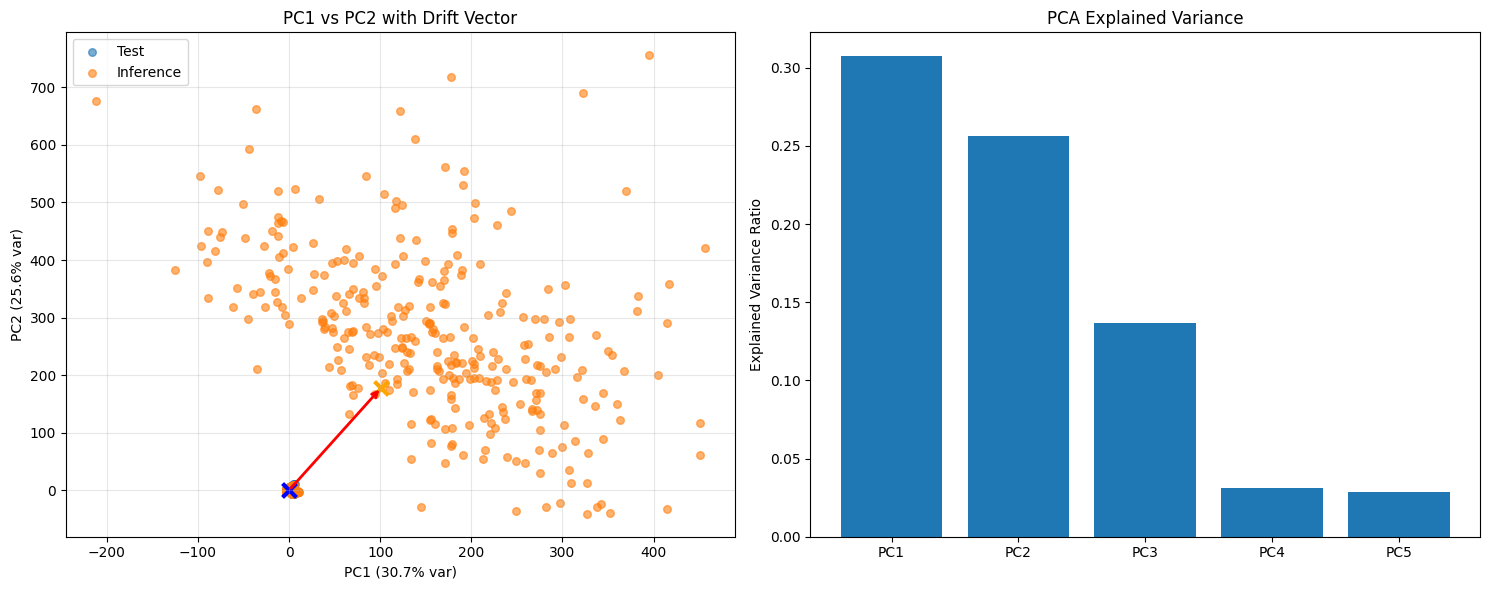

Drift Distance: 295.679
High drift (>1σ) in: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']


{'pca': PCA(n_components=5),
 'explained_variance_ratio': array([0.30731272, 0.25639559, 0.1368075 , 0.03134933, 0.02863398]),
 'loadings_df':                           PC1       PC2       PC3       PC4       PC5
 x_mean               0.181579  0.142895 -0.198842  0.002891  0.054537
 x_std                0.187487  0.148288 -0.192626  0.024469  0.017590
 x_max                0.186731  0.148054 -0.195883  0.009253  0.036116
 x_min               -0.033765 -0.046543  0.016772 -0.264318  0.403010
 x_range              0.186732  0.148545 -0.195422  0.015757  0.025975
 x_skew               0.185163  0.148386 -0.195374 -0.000191  0.043956
 x_kurtosis           0.185356  0.146799 -0.194126 -0.003784  0.036379
 x_n_peaks           -0.181516 -0.148444  0.175973  0.011568 -0.062638
 x_energy             0.187240  0.146877 -0.191979  0.022943  0.010269
 y_mean               0.086287  0.183616  0.246121  0.055909  0.058398
 y_std                0.091980  0.195705  0.234647 -0.097308 -0.049391
 y_max

In [23]:
# non categorical features
features = [
    "x_mean", "x_std", "x_max", "x_min", "x_range", "x_skew", "x_kurtosis", "x_n_peaks", "x_energy",
    "y_mean", "y_std", "y_max", "y_min", "y_range", "y_skew", "y_kurtosis", "y_n_peaks", "y_energy",
    "z_mean", "z_std", "z_max", "z_min", "z_range", "z_skew", "z_kurtosis", "z_n_peaks", "z_energy",
    "mag_mean", "mag_std", "mag_max", "max_delta_mag", "sudden_change_score",
    "x_fft_max", "x_fft_mean", "y_fft_max", "y_fft_mean", "z_fft_max", "z_fft_mean",
    "xy_corr", "xz_corr", "yz_corr",
    "temperature", "humidity", "altitude", "battery_level", "gps_accuracy"
]

res = run_pca(df_inf, df_test, features, n_components=5)
plot_pca(res)

In [24]:
def top_loadings(loadings_df, n_pcs=5, top_k=5):
    """
    Print top-k features (by absolute loading) for each PC in separate tables.
    """
    results = {}
    for pc in [f"PC{i+1}" for i in range(n_pcs)]:
        sub = loadings_df[[pc]].copy()
        sub["abs"] = sub[pc].abs()
        top = sub.nlargest(top_k, "abs").drop(columns="abs")
        results[pc] = top
        print(f"\nTop {top_k} loadings for {pc}:")
        display(top)  # works nicely in Jupyter
    

print(f"Drift values of PC1->PC5 {res['pc_drift_magnitudes']}")
top_loadings(res["loadings_df"], n_pcs=5, top_k=5)


Drift values of PC1->PC5 [26.927109902640733, 51.95816057992111, 18.380909731295638, 60.8788555788245, 169.55051313872764]

Top 5 loadings for PC1:


,PC1
max_delta_mag,0.213152
mag_std,0.211913
z_fft_mean,0.207946
z_range,0.207825
z_min,-0.207601



Top 5 loadings for PC2:


,PC2
mag_max,0.232639
mag_mean,0.209424
y_skew,0.197805
y_max,0.197629
y_range,0.196787



Top 5 loadings for PC3:


,PC3
y_fft_mean,0.253134
y_max,0.248878
y_range,0.247403
y_mean,0.246121
y_skew,0.244991



Top 5 loadings for PC4:


,PC4
y_min,0.458706
z_n_peaks,0.428102
temperature,0.356568
y_n_peaks,0.344961
humidity,-0.267894



Top 5 loadings for PC5:


,PC5
temperature,0.479808
x_min,0.403010
battery_level,-0.349844
humidity,0.325080
z_max,-0.278090


## Results
So we transformed the inference data on the test basis and plotted our results. The first plot (left) portrays the drift of the inference set. We can see that theres a high concentration of both test and inference samples around the origin (0,0). This is because we fit our test data and so when we transform it onto the generated axis it would be expected to not drift. However, there are a large number of inference samples that have a significant drift from that origin. We also have an arrow representing the magnitude and drift of the inference data. The fact that it shows a strong drift in both PC1 and PC2 indicates that this is not random noise but a consistant difference in driving patterns. 

Since PC1(30.7%) and PC2(25.6%) together capture most (56%) of the variation of the test set, we can put our emphasis on them. We can see that the top contributors for:

PC1 - 27 stds from test:
```max_delta_mag, mag_std, z_fft_mean, z_range, z_min```

Although with respect to the other drift values of the other PCs a value of 27 seems low, it is still extreamly large. It indicates that the inference data has much more intense forward and backward acceleration changes compared to the test data as well as overall magnitude. 

PC2 - 52 stds from test:
```mag_max, mag_mean, y_skew, y_max, y_range```
This is an even harsher drift in the y-axis, indicating much more bumps and vertical change. This aligns with the SMD we looked at in the previous cells and confirms the movement of the car in the inference set is much more energetic.

### Summary
In summary, it is clear that the different sets are different from each other by nature. The difference in metrics was likely caused because the data in which the random forest model was trained on not representative of the true data which the model would actually take in production. This meant that when the inference data was used as input, many samples were classified as positives falsly because most of the test data was likely taken from events of a car driving straight on a smooth road. 

In [25]:
# In this work I did not use catagorical features due to time constraints, but just out of intereset i want to compare the road type proportions.
rt_inf = df_inf["road_type"]
rt_test = df_test["road_type"]

rt_props = pd.DataFrame({
    "inference": rt_inf.value_counts(normalize=True),
    "test": rt_test.value_counts(normalize=True)
}).fillna(0)

print(rt_props)
print("The road type here doesnt indicate much regarding the diffs in data")

           inference   test
road_type                  
highway     0.306554  0.370
rural       0.340381  0.285
urban       0.353066  0.345
The road type here doesnt indicate much regarding the diffs in data


### Immidiate workaround
For the immidiate workaround, one of the things we can try is to set a threshold value by the probability number. The model is sensitive as shown by the difference in recall and precision. One of the first example cells used the method: ```model.predict_proba(df_inf)```. Instead of calling predict() to predict if its a collision, we can manually set a threshold high enough to overwrite the predict() method and classify less false positives. 

Another thing that can be tried is scaling down some features to match the distribution of the test set. This is possible since we know the mean and std of the test set and can be done with normalisation. We convert the distribution of a feature in the inference set to a standard normal distribution, putting the mean at 0 and normalising the std. We then multiply by the test's std and shift by its mean. This will transform values from the inference set onto the test's "space". 

### Long term solution
The obvious long term solution would be to fine tune or retrain the model. First, better training data would be required. Both data from the test set and the inference set should be used as together they would contribute to creating a more diverse, generalised model. If data from the inference set is not available in large enough amounts, data augmentation can be used. Now that we have evaluated the differences between the two sets we can use the data we gathered to augment and transform the old training data to be similar to data taken from the inference set. Also, if the annotation is in our control, and we know wether a road is going to be bumpy or chaotic at each sample, we can add another feature for "bumpiness_score" which should lower the number of false positives. 


# ❓ Questions to Reflect On

I hope I answered most of these during the EDA task :)

- What do you observe when comparing the model’s predictions on the new data to its known performance?

When comparing the predictions made by the model on both sets, I see that the recall remains high with respect to the test data, but the precision and accuracy are lower. This is because the model has classified a high number of false positives when making predictions on the inference data. 

- Is there anything in the data that might explain differences in behavior?

Yes, the movement of the vehicle along its axis is much more erratic in the inference dataset. Assuming the data was trained on similar data to the test set, the model is much more likely to classifiy a sample from the inference set as a collision when it is not, since it hasnt been trained on this type of data and was likely overfitted and trained on a very narrow distribution and samples with simple conditions and a good driver. 

- Can you identify patterns or trends related to when the model succeeds or fails?

The model would likely succeed on the inference set if the sample describes a vehicle which is stable and driving on a smooth flat road with minimal changes in accelerations. It would typically fail with an increase in changes in movement. 

- Are there signals or features that seem to affect the model’s reliability?

Yes, as discussed previously, there are a few features which would make the model unreliable. One of them is "y_energy", the mean of this feature was shown to be 380 standard diviations from the test basis. This means it is extreamly different by nature and could a significant cause to the high number of false positives. Just as a side note, throughout this notebook I thought the y movement is vertical, i.e. bumpy, and z movement would be acceleration. I was aware that in IMU convention it’s the opposite. This doesn’t change the main conclusion but I might have made a few errors when talking about the context of the values i was referring to.

- What could be done in the short term to handle the current situation?

Any new input that is similar to the inference set can be scaled as described in the cell above. By normalisation and scaling to match the test's distribution. And also set a threshold on the probability values outputted by the model. 

- What are potential long-term steps to improve model performance in similar scenarios?

The long term steps would be to gather inference data and use it as training alone with the test data. This would help to avoid overfitting and produce a more diverse and general model. If thats not possible use augmentation on the normal training data. 

- What would you want to explore further if given more time or data?

Understand the effect the categorical features have. Due to time constraints I didnt evalute features such as time of day, firmaware, and vehicle type as I prioritised them less than the numerical movement values. However, they likely do have a contribution. An example of snowy weather conditions causing a slippery road could be significant for evaluation like this. In addition, SMD and PCA are just a few techniques that can be used for this. A KS test could have also be used to better understand how two distributions differ from each other.

- What assumptions did the model rely on during training — and are they still valid?

The main assumption the model relied on is that the the driver, the road, and the car would be ideal for all scenarios. This made the model not diverse and overfitted. This assumption was valid in training and testing but not in production scenarios. 